In [ ]:
from fastai.vision.all import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS) 
path_hr = path/'images'
path_lr = path/'crappy'

In [3]:
path

Path('/home/sandmann/.fastai/data/oxford-iiit-pet')

In [4]:
Path.BASE_PATH = path

In [5]:
import gc

In [27]:
gc.collect()

209

In [6]:
path_hr.ls()

(#7393) [Path('images/Birman_115.jpg'),Path('images/leonberger_142.jpg'),Path('images/Bombay_68.jpg'),Path('images/japanese_chin_26.jpg'),Path('images/saint_bernard_149.jpg'),Path('images/Ragdoll_41.jpg'),Path('images/japanese_chin_32.jpg'),Path('images/Ragdoll_68.jpg'),Path('images/Persian_202.jpg'),Path('images/scottish_terrier_143.jpg')...]

In [7]:
path_lr.ls()

(#7390) [Path('crappy/Birman_115.jpg'),Path('crappy/leonberger_142.jpg'),Path('crappy/Bombay_68.jpg'),Path('crappy/japanese_chin_26.jpg'),Path('crappy/saint_bernard_149.jpg'),Path('crappy/Ragdoll_41.jpg'),Path('crappy/japanese_chin_32.jpg'),Path('crappy/Ragdoll_68.jpg'),Path('crappy/Persian_202.jpg'),Path('crappy/scottish_terrier_143.jpg')...]

# Pre-train generator

In [8]:
bs, size = 16, 128
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()

In [21]:
arch = partial(resnet34, pretrained=True)

In [18]:
def get_dls(bs, size):
    dblock = DataBlock(
        blocks=(ImageBlock, ImageBlock),
        get_items = get_image_files,
        get_y = lambda x: path_hr/x.name,
        splitter = RandomSplitter(),
        item_tfms = Resize(size),
        batch_tfms = [*aug_transforms(max_zoom=2.)]
    )
    dls = dblock.dataloaders(path_lr, bs=bs, path=path)
    dls.c = 3
    return dls

In [19]:
dls_gen = get_dls(bs, size)

In [13]:
dls_gen.c

3

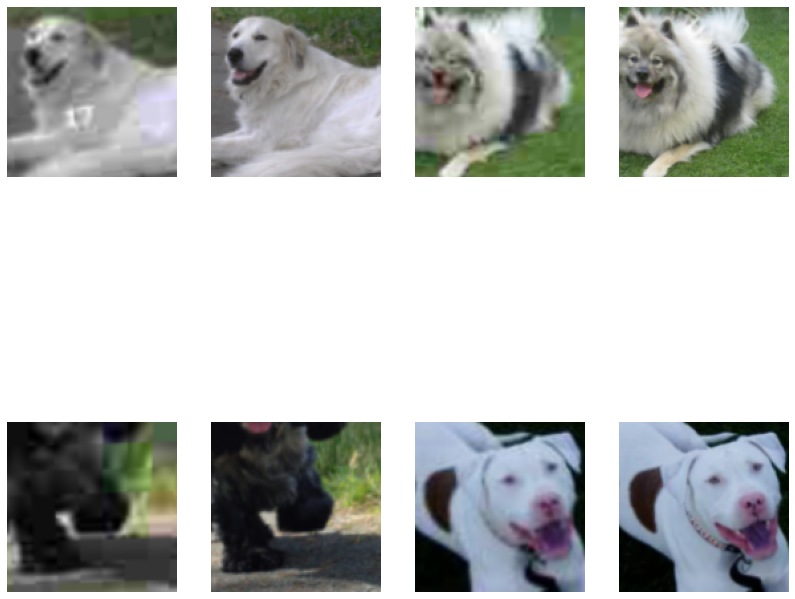

In [14]:
dls_gen.show_batch(max_n=4, figsize=(14,14))

In [16]:
def create_gen_learner():
    return unet_learner(dls_gen, arch, loss_func=loss_gen, blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range)

In [16]:
learn_gen = create_gen_learner()

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=9.120108734350652e-05)

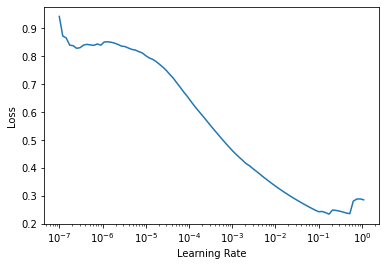

In [18]:
learn_gen.lr_find()

In [26]:
#learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.003653,0.003237,02:25
1,0.002025,0.002094,02:12


In [ ]:
# no batch_tfms -> valid loss: 0.2%
# aug_transforms -> valid loss: 0.2%
# Normalize from stats -> 3.8%
# both -> 3.5%

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=6.309573450380412e-07)

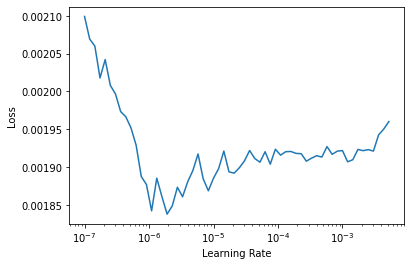

In [27]:
#learn_gen.lr_find()

In [19]:
learn_gen.fit_one_cycle(2, 1e-2, wd=wd) 

epoch,train_loss,valid_loss,time
0,0.002369,0.002101,02:03
1,0.001837,0.001872,02:04


In [20]:
# no batch_tfms -> valid loss: 0.19%
# aug_transforms -> valid loss: 0.19%
# Normalize from stats ->  3.5%
# both -> 3.4%

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=1.0964781722577754e-06)

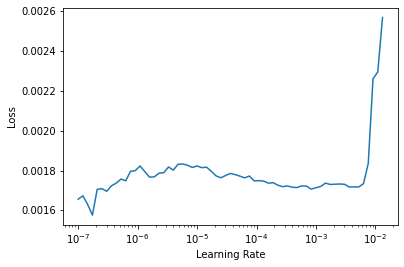

In [21]:
learn_gen.lr_find()

In [22]:
learn_gen.unfreeze()

SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=6.309573450380412e-07)

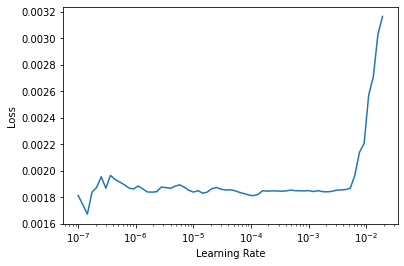

In [23]:
learn_gen.lr_find()

In [24]:
learn_gen.freeze()

SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=1.3182567499825382e-06)

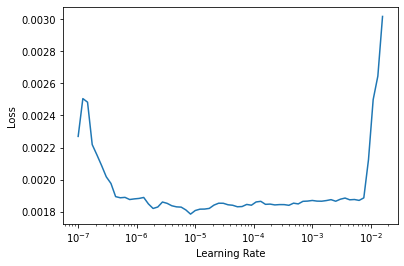

In [25]:
learn_gen.lr_find()

In [26]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.001841,0.001891,02:19
1,0.001820,0.001817,02:13
2,0.001796,0.001806,02:16


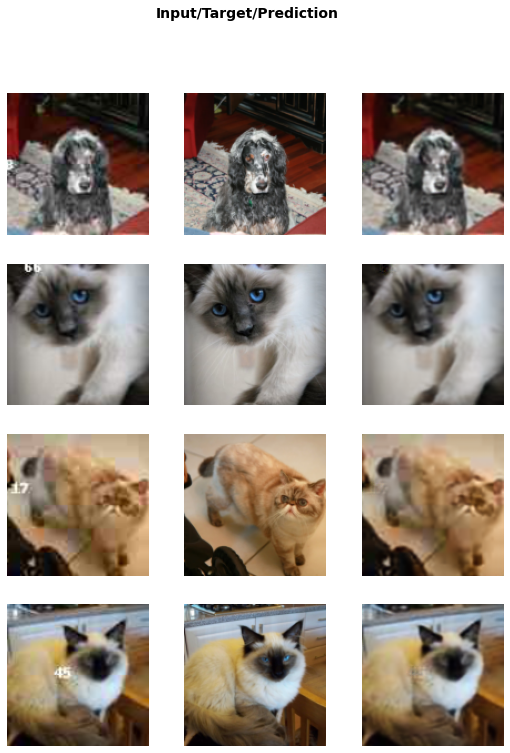

In [16]:
learn_gen.show_results(max_n=4)

In [29]:
#learn_gen.save('gen-pre2')

Path('models/gen-pre2.pth')

# Save generated images

In [17]:
learn_gen.load('gen-pre2');

In [18]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [19]:
path_gen.ls()

(#5912) [Path('image_gen/Birman_115.jpg'),Path('image_gen/leonberger_142.jpg'),Path('image_gen/Bombay_68.jpg'),Path('image_gen/saint_bernard_149.jpg'),Path('image_gen/Ragdoll_41.jpg'),Path('image_gen/japanese_chin_32.jpg'),Path('image_gen/Persian_202.jpg'),Path('image_gen/scottish_terrier_143.jpg'),Path('image_gen/Bombay_215.jpg'),Path('image_gen/Bengal_69.jpg')...]

In [19]:
#shutil.rmtree(path_gen)

In [18]:
path_gen.mkdir(exist_ok=True)

In [19]:
def save_preds(dl, learn):
    names = dl.dataset.items
    
    preds,_ = learn.get_preds(dl=dl)
    for i,pred in enumerate(preds):
        dec = dl.after_batch.decode(TensorImage(pred[None]))[0]
        arr = dec.numpy().transpose(1,2,0)
        Image.fromarray(np.uint8(arr), mode='RGB').save(path_gen/names[i].name)

In [20]:
#dl = dls_gen.train.new(shuffle=False, drop_last=False, after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
dl = dls_gen.train.new(shuffle=False, drop_last=False, after_batch=[IntToFloatTensor])

In [21]:
save_preds(dl, learn_gen)

In [22]:
path_gen.ls()

(#5912) [Path('image_gen/Birman_115.jpg'),Path('image_gen/leonberger_142.jpg'),Path('image_gen/Bombay_68.jpg'),Path('image_gen/saint_bernard_149.jpg'),Path('image_gen/Ragdoll_41.jpg'),Path('image_gen/japanese_chin_32.jpg'),Path('image_gen/Persian_202.jpg'),Path('image_gen/scottish_terrier_143.jpg'),Path('image_gen/Bombay_215.jpg'),Path('image_gen/Bengal_69.jpg')...]

In [23]:
generated = get_image_files(path_gen)

In [29]:
preds,_ = learn_gen.get_preds()

In [32]:
pred = preds[0]

In [31]:
dl_gen = gen_learner_norm.dl;

In [45]:
dec = dl_gen.after_batch.decode(TensorImage(pred[None]))[0]

In [46]:
dec.shape

torch.Size([3, 128, 128])

In [50]:
type(dec)

fastai.torch_core.TensorImage

In [52]:
arr = dec.numpy().transpose(1,2,0)
arr.shape

(128, 128, 3)

In [82]:
arr[0][0]

array([76, 76, 71])

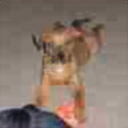

In [85]:
Image.fromarray(np.uint8(arr), mode='RGB')

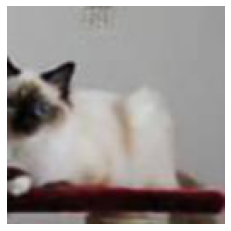

In [24]:
PILImage.create(generated[0]).show();


# Train critic

In [20]:
def get_crit_dls(bs,size):
    crit_dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items = partial(get_image_files, folders=['images', name_gen]),
        get_y = parent_label,
        splitter= RandomSplitter(0.1, seed=42),
        item_tfms = Resize(size),
        batch_tfms = [*aug_transforms(max_zoom=2.), Normalize.from_stats(*imagenet_stats)]
    )
    return crit_dblock.dataloaders(path, bs=bs, path=path)

In [21]:
dls_crit = get_crit_dls(bs, size)

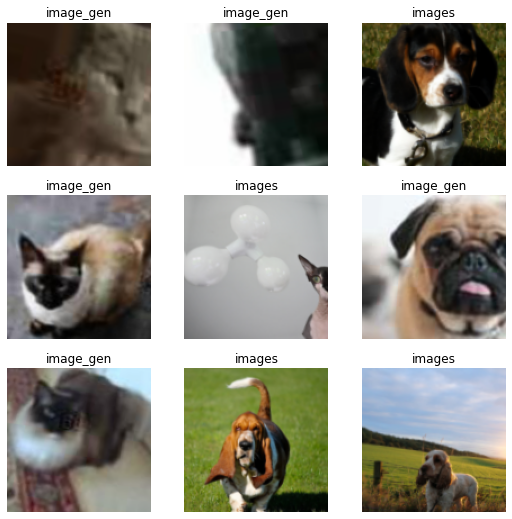

In [22]:
dls_crit.show_batch()

In [13]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [11]:
def create_critic_learner(dls, metrics):
    return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_critic)

In [25]:
learn_critic = create_critic_learner(dls_crit, accuracy_thresh_expand)

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=0.9120108485221863)

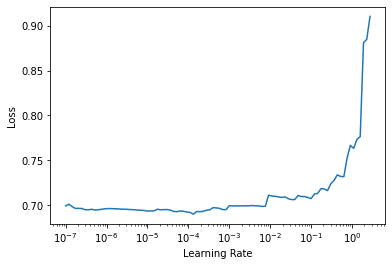

In [26]:
learn_critic.lr_find()

In [35]:
learn_critic.fit_one_cycle(6, 1e-3, wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.685940,0.688066,0.559398,05:22
1,0.682530,0.685475,0.559398,05:26
2,0.682288,0.676259,0.559398,05:26
3,0.418526,0.589085,0.658496,05:27
4,0.309416,0.341524,0.819248,05:27
5,0.280168,0.338177,0.818977,05:27


SuggestedLRs(lr_min=0.00011481536785140634, lr_steep=2.1379621557571227e-06)

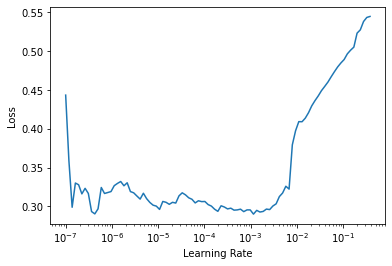

In [36]:
learn_critic.lr_find(end_lr=1)

In [37]:
#learn_critic.save('critic-pre2')

Path('models/critic-pre2.pth')

In [28]:
learn_critic.load('critic-pre2'); # after 6 epochs 1e-3, 2 epochs slice(1e-5,1e-3) for valid loss of 0.068

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=1.3182567499825382e-06)

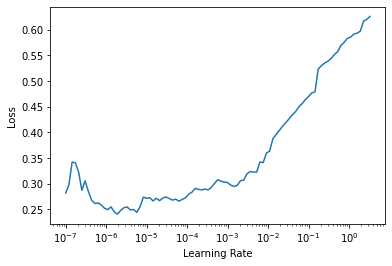

In [29]:
learn_critic.lr_find()

In [30]:
learn_critic.fit_one_cycle(2, slice(1e-5,1e-3), wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.274108,0.610759,0.701534,06:37
1,0.154033,0.124715,0.948631,05:17


SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=3.981071586167673e-06)

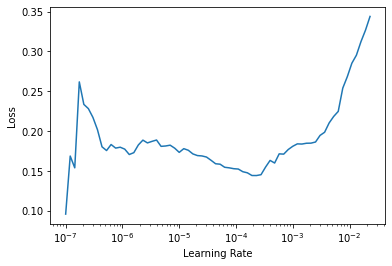

In [31]:
learn_critic.lr_find()

In [34]:
#learn_critic.save('critic-pre3');

In [35]:
learn_critic.fit_one_cycle(2, slice(1e-6,1e-4), wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.152275,0.128183,0.947579,05:14
1,0.127630,0.099385,0.962677,05:19


SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=6.309573450380412e-07)

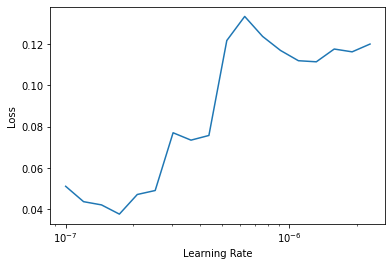

In [36]:
learn_critic.lr_find()

In [38]:
#learn_critic.save('critic-pre4')

In [45]:
learn_critic.load('critic-pre4');

# GAN

In [28]:
def get_crit_dls(bs,size):
    crit_dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items = partial(get_image_files, folders=['crappy', 'images']),
        get_y = parent_label,
        splitter = RandomSplitter(0.1, seed=42),
        item_tfms = Resize(size),
        batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    )
    return crit_dblock.dataloaders(path, bs=bs, path=path)

In [29]:
dls_crit = get_crit_dls(bs, size)

In [30]:
learn_crit = create_critic_learner(dls_crit, metrics=None).load('critic-pre4')

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 4.00 GiB total capacity; 2.93 GiB already allocated; 0 bytes free; 2.97 GiB reserved in total by PyTorch)

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2')

In [ ]:
GANDiscriminativeLR()

In [23]:
switcher = AdaptiveGANSwitcher(critic_thresh=0.65)

In [24]:
learn = GANLearner.from_learners(learn_gen, learn_crit, switcher=switcher, weights_gen=(1.,50.), show_img=False,
                                opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [25]:
learn.lr_find()

/home/sandmann/anaconda3/envs/fastbook/lib/python3.8/site-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/sandmann/anaconda3/envs/fastbook/lib/python3.8/site-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/sandmann/anaconda3/envs/fastbook/lib/python3.8/site-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 4.00 GiB total capacity; 2.88 GiB already allocated; 0 bytes free; 2.92 GiB reserved in total by PyTorch)

In [26]:
learn.fit(10, 1e-4, wd=wd)

epoch,train_loss,valid_loss,gen_loss,crit_loss,time


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 4.00 GiB total capacity; 2.89 GiB already allocated; 0 bytes free; 2.94 GiB reserved in total by PyTorch)